## 深度学习演示2：实现一个最简单的Deep Dream

Deep Dream是一个非常有趣的算法，利用已经训练好的卷积网络模型，对输入图像进行反向修改，放大卷积网络中某部分的输出。

这里演示一个最简单的反向图像生成。和之前的演示一样，我们同样使用VGG的ImageNet模型。

* Google的论文和伪代码

https://github.com/google/deepdream 

* 基于Python和Caffe的实现

https://github.com/jrosebr1/bat-country

https://github.com/jcjohnson/cnn-vis

＊ 基于Torch的实现

https://github.com/eladhoffer/DeepDream.torch 

https://github.com/Teaonly/easyDreaming (鄙人的简单实现）


### 1. 裁减模型，去掉顶部的全连接层


In [1]:
require('nn')

cnnModel = nn.Sequential()
local fullModel = torch.load('./net.bin') --装载原始模型
for i = 1, 23 do
    cnnModel:add( fullModel.modules[i] )
end
cnnModel:float()
cnnModel:evaluate()

meta = torch.load('./meta.bin')
meta.channelMean = {};
for i = 1, 3 do
    meta.channelMean[i] = torch.mean( meta.mean[{i, {}, {} }] )
end

collectgarbage()

### 2. 准备图像以及预处理

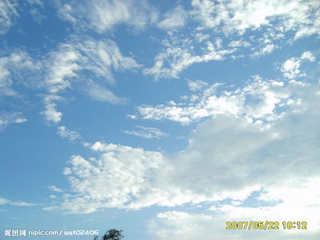

In [2]:
require('image')

orignalImg = image.loadPNG('./input.png', 3)
itorch.image(orignalImg)

orignalImg = orignalImg:float() * 256
for j = 1, 3 do
  orignalImg[{j, {}, {}}] = orignalImg[{j, {}, {}}] - meta.channelMean[j] 
end


### 3. 实施Deep Dream

In [3]:
local maxIterator = 20     --迭代次数

-- 首先定义clip图像值域范围的函数
local clipImage = function(img)
  channelMean = meta.channelMean
  for i = 1, 3 do
    local pixels = img[{i,{},{}}]:storage()
    for j = 1, pixels:size() do
      if ( pixels[j] < -1 * channelMean[i] ) then
        pixels[j] = -1 * channelMean[i]
      elseif (pixels[j] > 255 - channelMean[i]) then
        pixels[j] = 255 - channelMean[i]
      end
    end
  end
end

enhenceImage = function(inputImage)
    local targetImg = inputImage:clone()
    for i = 1, maxIterator do
        local inputOuput = cnnModel:forward(targetImg)

        -- 从神经网络的输出层，制造loss函数，输出 dloss
        local amplifyDiff = inputOuput:clone()
        amplifyDiff:mul(-1) -- 乘以－1，表示放大这个神经层

        inputOuput = cnnModel:backward(targetImg, amplifyDiff)
        local scale = 1.5 / torch.mean(torch.abs(inputOuput))

        targetImg:add(inputOuput*(-1*scale))
        clipImage(targetImg)

        --collectgarbage()
    end
    for j = 1, 3 do
      targetImg[{j, {}, {}}] = targetImg[{j, {}, {}}] + meta.channelMean[j] 
    end
    targetImg = targetImg / 256
    return targetImg
end

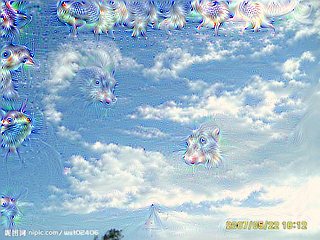

In [4]:
local outImage = enhenceImage(orignalImg)
itorch.image(outImage)